In [1]:
# 그래프상에서 한글을 나타내기 위해 korean_mat 설치
! pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

In [2]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_movie_total = pd.read_excel('movie_finished_toFDA_변수설명.xlsx', sheet_name='데이터')
df_movie_총관객 = pd.read_excel('movie_finished_toFDA_변수설명.xlsx', sheet_name='총매출액')
df_movie_상영기간 = pd.read_csv('movie_term.csv', index_col=0,encoding='cp949')

In [4]:
df_movie_상영기간.head()

,영화명,상영기간(주)
Unnamed: 0,,
0,데드풀,9
1,주토피아,21
2,대니쉬 걸,14
3,쿵푸팬더3,10
4,캐롤,74


In [5]:
df_movie_총관객['영화명'] = df_movie_총관객['영화명'].astype(str)
df_movie_total['movie_title'] = df_movie_total['movie_title'].astype(str)

print((set(df_movie_total['movie_title']) - set(df_movie_총관객['영화명'])))
df_movie_총관객 = df_movie_총관객[df_movie_총관객['영화명'].isin(list(set(df_movie_total['movie_title'])))].reset_index(drop=True) # 409개 영화에 대해 가져오기

# Processing to consolidate data
aggregated_df = df_movie_총관객[df_movie_총관객['영화명'].duplicated(keep=False)].groupby(['영화명']).agg({
    '누적매출액 ': 'max', # 누적 매출액
    '누적관객수 ': 'max', # 누적 관객수
    '스크린수 ': 'sum', # 스크린 수 총합
    '상영횟수 ': 'sum' # 상영횟수 총합
}).reset_index()

# 중복된 데이터 제거 후 병합
df_concat_총매출 = pd.concat([df_movie_총관객[~df_movie_총관객['영화명'].duplicated(keep=False)][aggregated_df.columns], aggregated_df], axis=0).reset_index(drop=True)

set()


In [6]:
#df_concat_총매출의 영화명 칼럼명을 movie_title로 변경
df_concat_총매출.rename(columns={'영화명':'movie_title'}, inplace=True)
df_movie_상영기간.rename(columns={'영화명':'movie_title'}, inplace=True)

In [7]:
# key 열을 기준으로 병합
df_movie_총기간 = pd.merge(df_concat_총매출, df_movie_상영기간, on='movie_title', how='outer')  # 기본은 inner join

In [8]:
#상영기간(주)과 movie_title열만 남기기
df_movie_총기간 = df_movie_총기간[['movie_title','상영기간(주)']]
df_movie_총기간.head()

,movie_title,상영기간(주)
0,0.0MHz,5
1,12 솔져스,13
2,1987,19
3,1급기밀,8
4,23 아이덴티티,6


In [9]:
df = pd.merge(df_movie_total, df_movie_총기간, on='movie_title', how='left')

In [10]:
#'수익성'칼럼 추가 - 누적매출액 / 개봉일 좌석수
df['최종 누적매출액'] = df.groupby('movie_title')['누적매출액'].transform('last')
df['개봉일_좌석수'] = df.groupby('movie_title')['좌석수'].transform('first')
df['수익성'] = df['최종 누적매출액'] / df['개봉일_좌석수']

In [11]:
df.head()

,naver_movie_code,kobis_movie_code,movie_title,release_date,DoW_release,Date,DoW,MoY,D_D,DailyTotal,...,등급평균스크린수,7days_before,5days_before,Day_of_release,5days_after,7days_after,상영기간(주),최종 누적매출액,개봉일_좌석수,수익성
0,107374,20142641,나를 잊지 말아요,42376,Thursday,42376,Thursday,January,0,612,...,79,11,11,13,6,33,6,3386696500,360219,9401.770867
1,107374,20142641,나를 잊지 말아요,42376,Thursday,42377,Friday,January,1,332,...,79,11,11,13,6,33,6,3386696500,360219,9401.770867
2,107374,20142641,나를 잊지 말아요,42376,Thursday,42378,Saturday,January,2,394,...,79,11,11,13,6,33,6,3386696500,360219,9401.770867
3,107374,20142641,나를 잊지 말아요,42376,Thursday,42379,Sunday,January,3,205,...,79,11,11,13,6,33,6,3386696500,360219,9401.770867
4,107374,20142641,나를 잊지 말아요,42376,Thursday,42380,Monday,January,4,246,...,79,11,11,13,6,33,6,3386696500,360219,9401.770867


In [12]:
#csv 파일로 저장
#df.to_csv('movie_finished_toFDA_변수추가.csv', index=False, encoding='cp949')

## 최종 데이터 위와 같음

In [13]:
#df = pd.read_csv('movie_finished_toFDA_변수추가.csv', encoding='cp949')

In [14]:
#개봉일 스크린수
df['개봉일_스크린수'] = df.groupby('movie_title')['스크린수'].transform('first')
df['개봉일_스크린점유율'] = df.groupby('movie_title')['스크린점유율'].transform('first')

In [15]:
def create_dummies(df, columns, drop_first=True): # 더미 변수 생성을 위한 함수
    return pd.get_dummies(df, columns=columns, drop_first=drop_first)

def convert_data_types(df): # True,False -> 0,1로 변환
    df.update(df.select_dtypes(include=['bool']).astype(int))
    return df

def apply_log_transformation(df, columns): # 로그 변환
    for column in columns:
        df[column] = np.log1p(df[column])
    return df

def compute_daily_averages(df, daily_columns, key='movie_title'): # 일별 데이터 집계
    daily_averages = df.groupby(key)[daily_columns].mean().reset_index()
    df = df.drop(columns=daily_columns).merge(daily_averages, on=key, how='left')
    return df.groupby(key).mean().reset_index()

### 개봉 방식별 EDA

#### 릴리즈 유형별 영화 수 분석

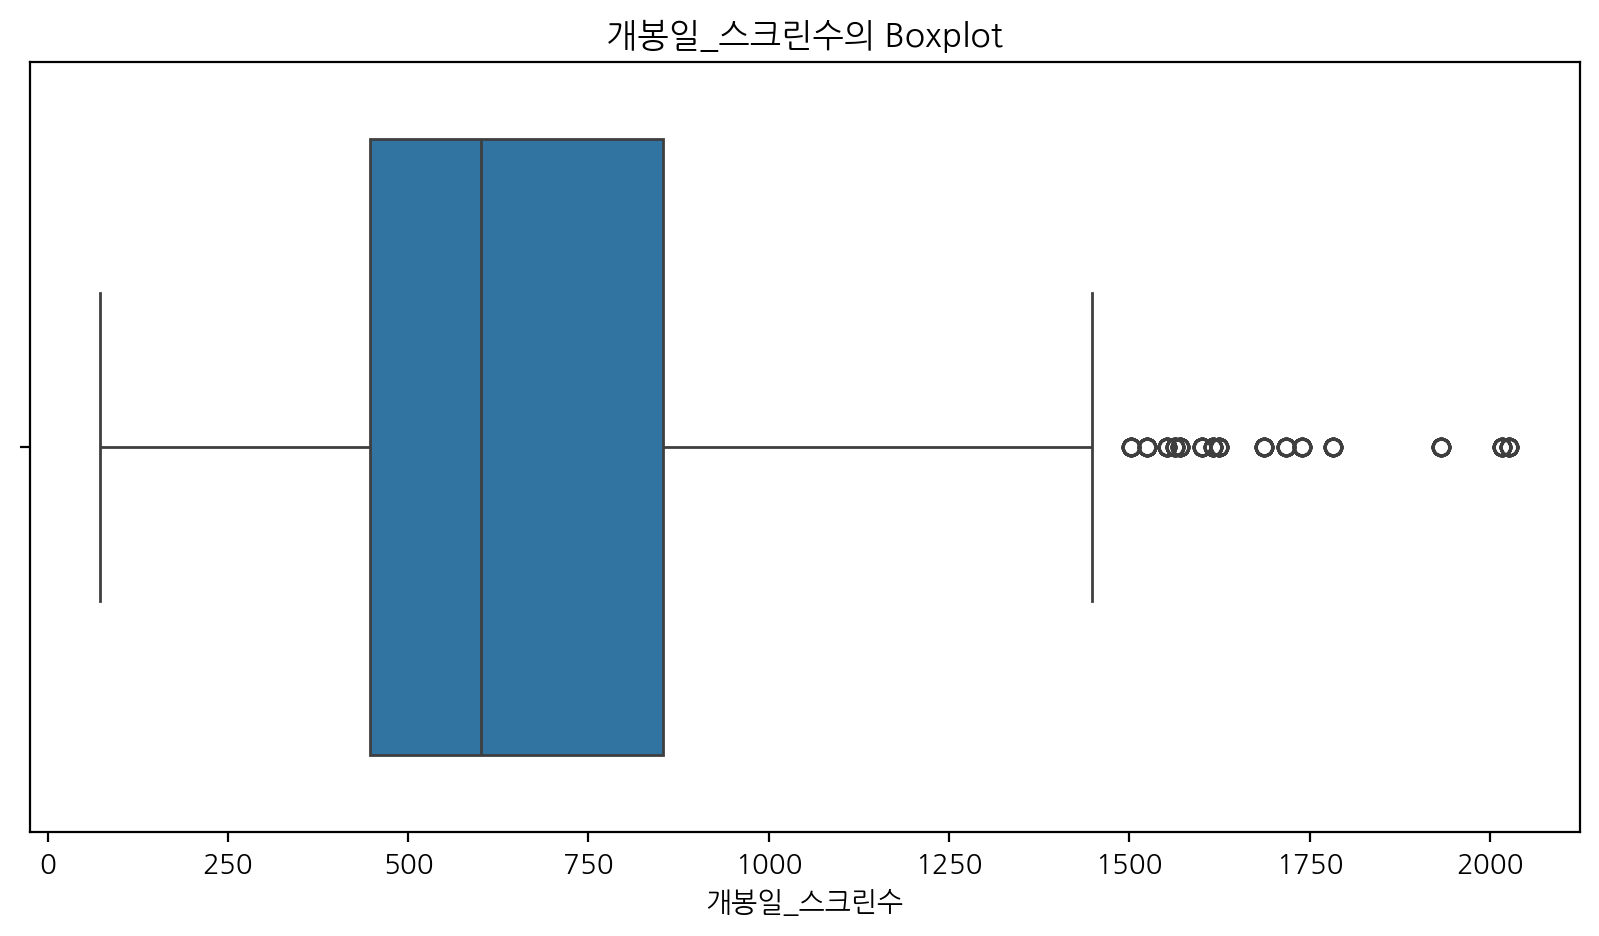

In [16]:
#개봉일_스크린수의 boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='개봉일_스크린수', data=df)
plt.title('개봉일_스크린수의 Boxplot')
plt.show()


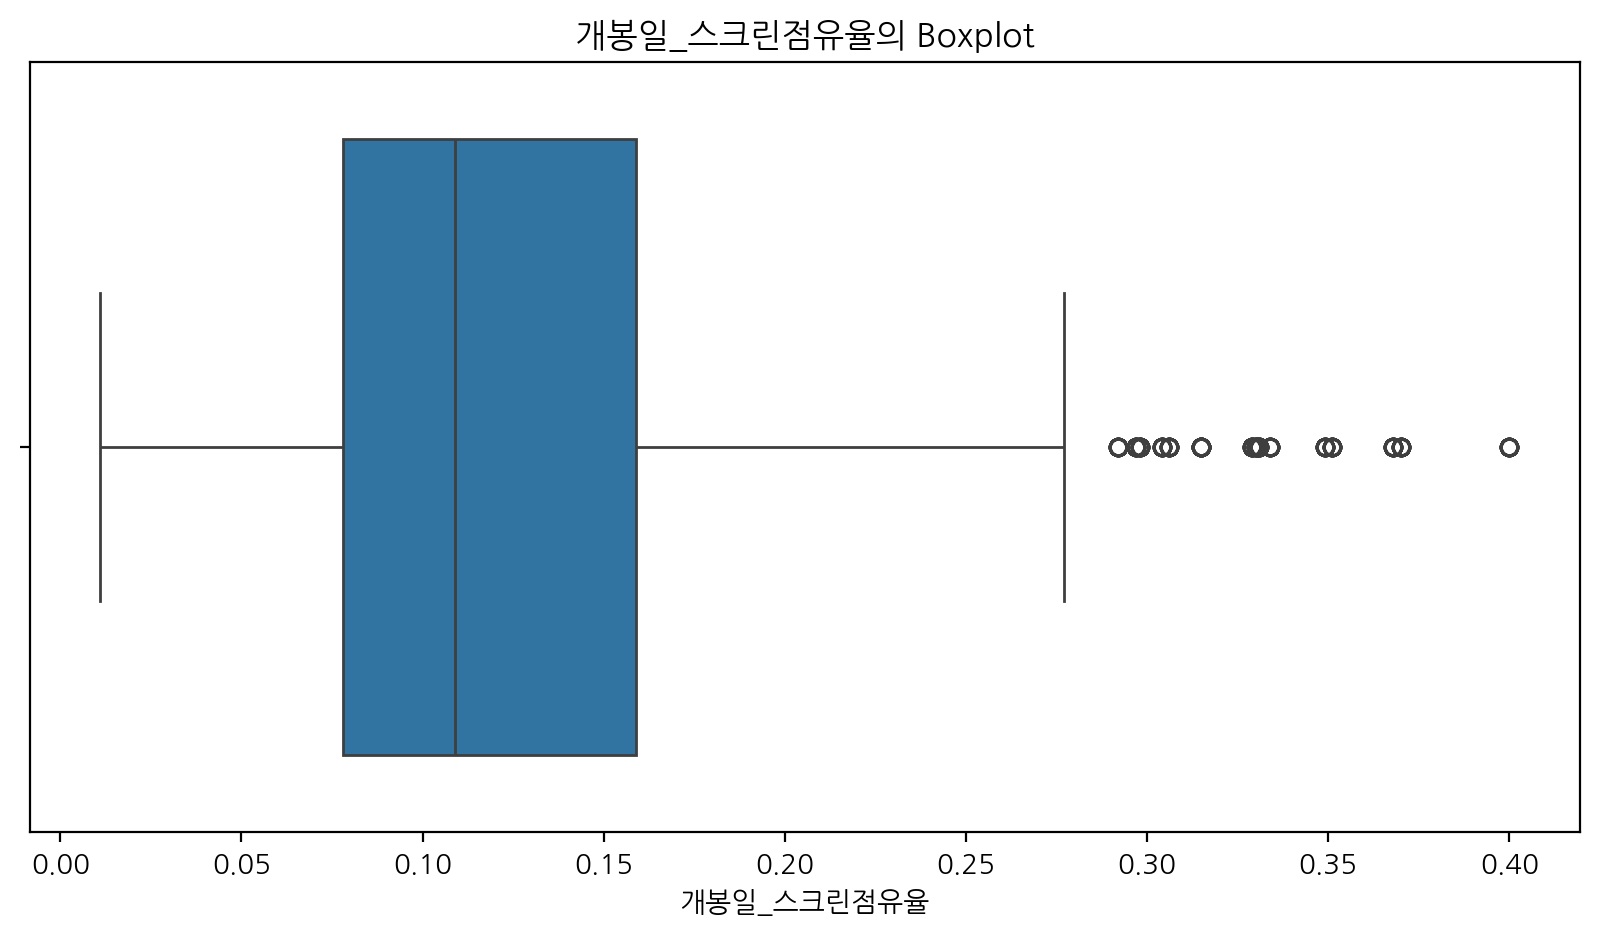

In [17]:
#개봉일_스크린수의 boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='개봉일_스크린점유율', data=df)
plt.title('개봉일_스크린점유율의 Boxplot')
plt.show() #스크린 점유율 max영화: 캡틴 마블

In [18]:
q1 = df['개봉일_스크린점유율'].quantile(0.25)
print(q1)
q3 = df['개봉일_스크린점유율'].quantile(0.75)
print(q3)
median = df['개봉일_스크린점유율'].median()
print(median)

# 3개 구간 나누기 (4분위 기반)
def categorize_screens(x):
    if x <= q1:
        return '내로우릴리즈 영화' # 내로우릴리즈 영화
    elif q1 < x <= 0.11:
        return '중간 단계 영화' # 중간 단계 영화      
    else:
        return '와이드릴리즈 영화' # 와이드릴리즈 영화   # 15%내외. 영화 시장의 점유율이 와이드릴리즈 영화에 치우쳐져 있어 중앙값인 0.11로 설정. 또한 논문에서 median 값을 기준으로 사용했음.

df['size_category'] = df['개봉일_스크린점유율'].apply(categorize_screens)

0.078
0.159
0.109


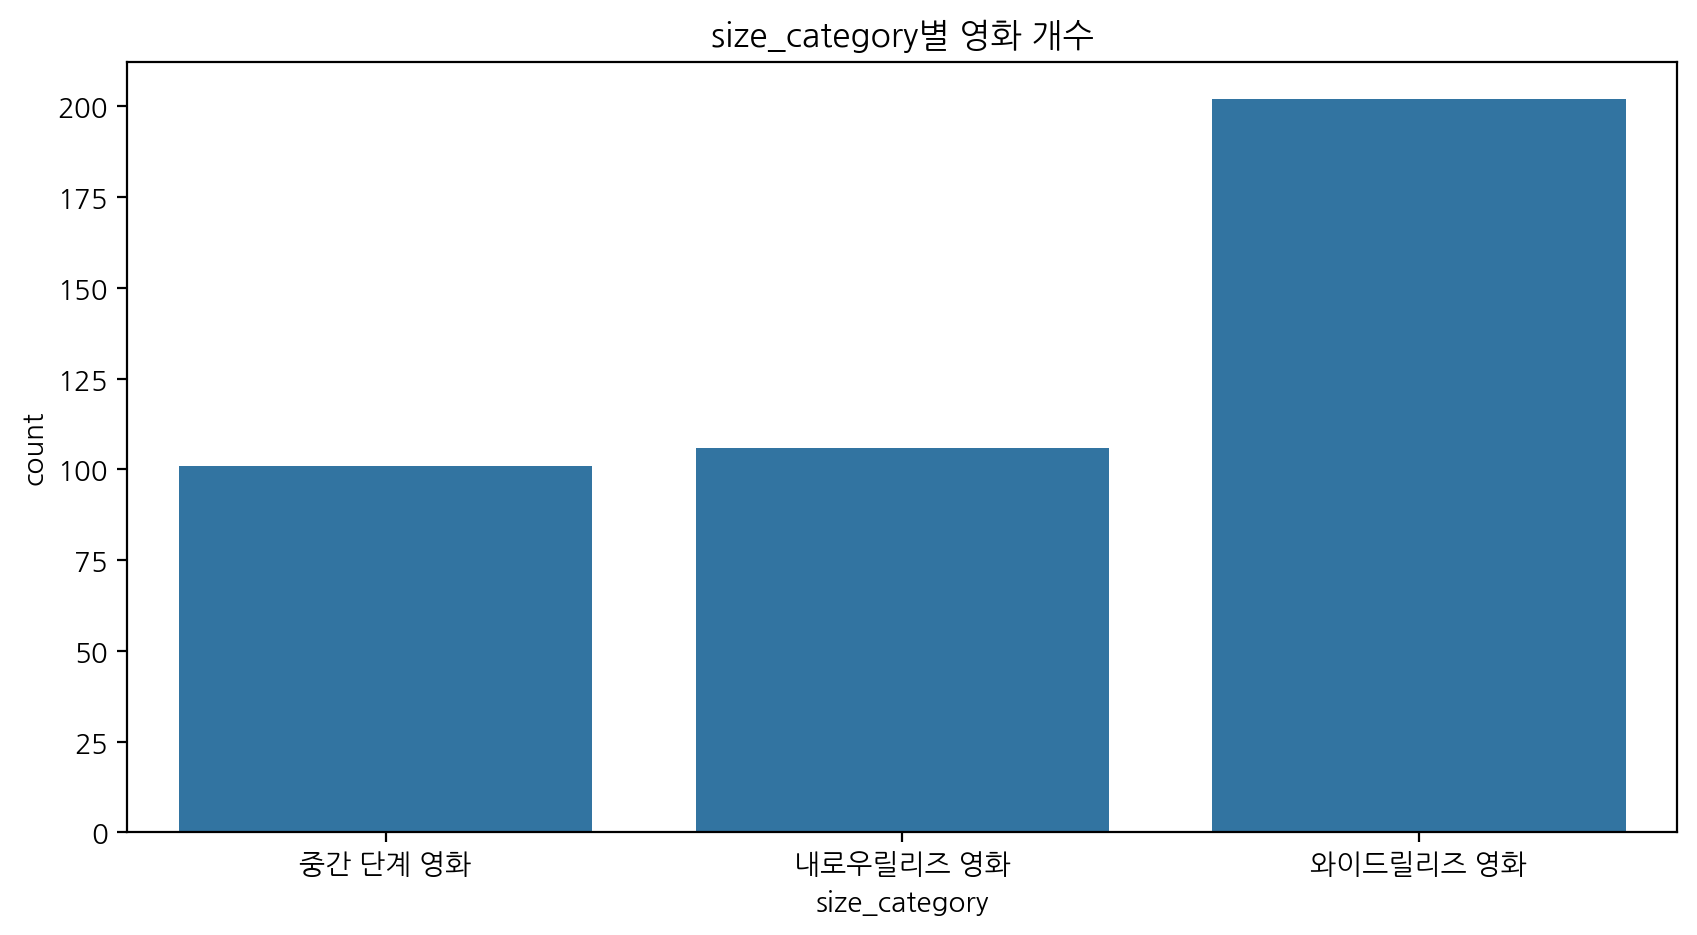

In [19]:
#size_catergory별 영화 개수 시각화(영화별로 중복을 제거한 후 분석)
data = df.drop_duplicates('movie_title')

plt.figure(figsize=(10, 5))
sns.countplot(x='size_category', data=data)
plt.title('size_category별 영화 개수')
plt.show()

#### 릴리즈 유형별 장르 분포
상대적으로 볼거리가 많고(ex. 액션, 어드벤처, 판타지, SF), 장르적 특성이 비교적 뚜렷한(ex. 범죄, 스릴러, 미스터리, 공포) 오락 영화들은 대체로 많은 수의 개
봉관을 확보하고자 하는 경향을 보이며, 오락성이 상대적으로 적거나 장르적 특성이 복합적인 드라마 장르의 영화들은 적은 수의 스크린을 통해 개봉되는 경향을 보이고 있다고는 말할 수 있을 것이다. 
30개 미만의 스크린으로 개봉되는 영화의 대부분은 드라마/멜로 장르, 애니메이션 장르, 다큐멘터리 장르의 영화였던 것이다. 이 결과를 통해, 영화의 장르별로 릴리즈 방식을 달리하는 차별화가 어느 정도 나타나고 있다고도 말할 수 있을 것이다. 

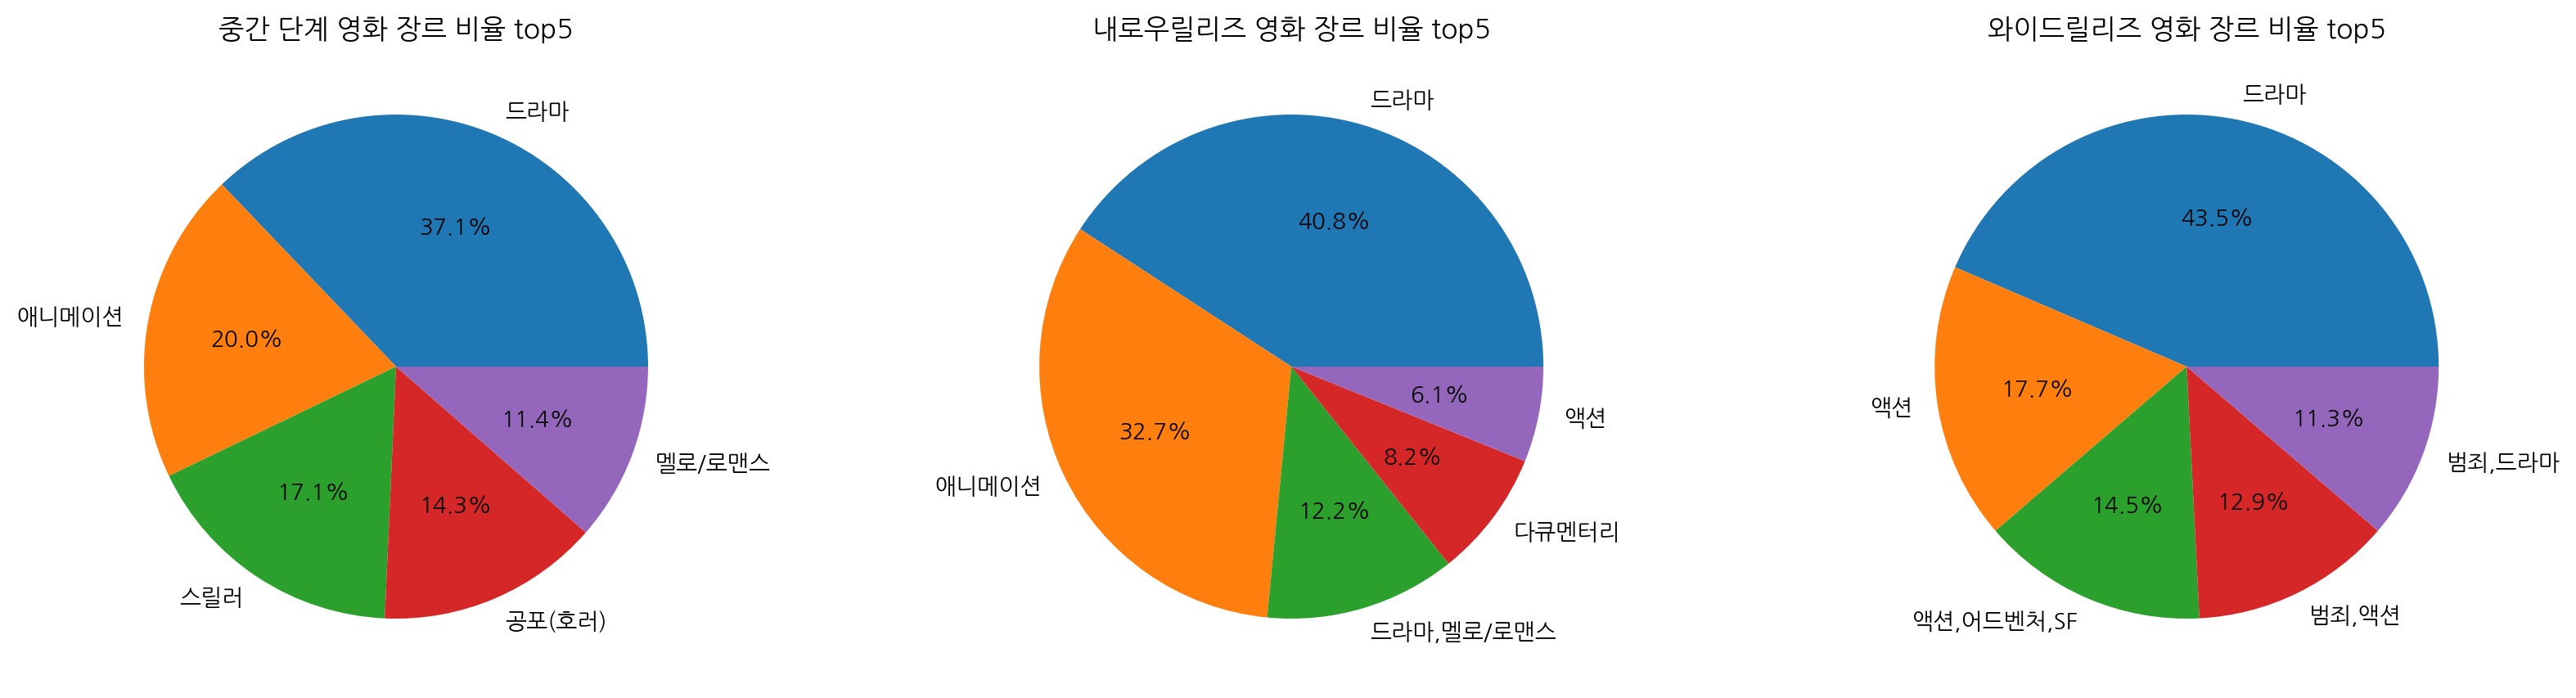

In [20]:
genre = ['사극', 'SF', '어드벤처', '액션', '범죄', '판타지', '가족', '미스터리', '스릴러', '뮤지컬', '코미디', '공포(호러)', '애니메이션', '드라마', '서부극(웨스턴)', '전쟁', '멜로/로맨스', '기타', '다큐멘터리', '공연', '성인물(에로)']
#릴리즈 유형별 장르 비율 시각화 - 영화별로 중복을 제거한 후 분석 (label은 top5에 해당하는 장르만 표시)
#원그래프로 표현, subplot으로 표현
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, size_category in enumerate(df['size_category'].unique()):
    data = df[df['size_category'] == size_category].drop_duplicates('movie_title')
    data = data['genre'].value_counts(normalize=True).head(5)
    ax[i].pie(data, labels=data.index, autopct='%1.1f%%')
    ax[i].set_title(f'{size_category} 장르 비율 top5')
plt.show()
#오락장르 여부

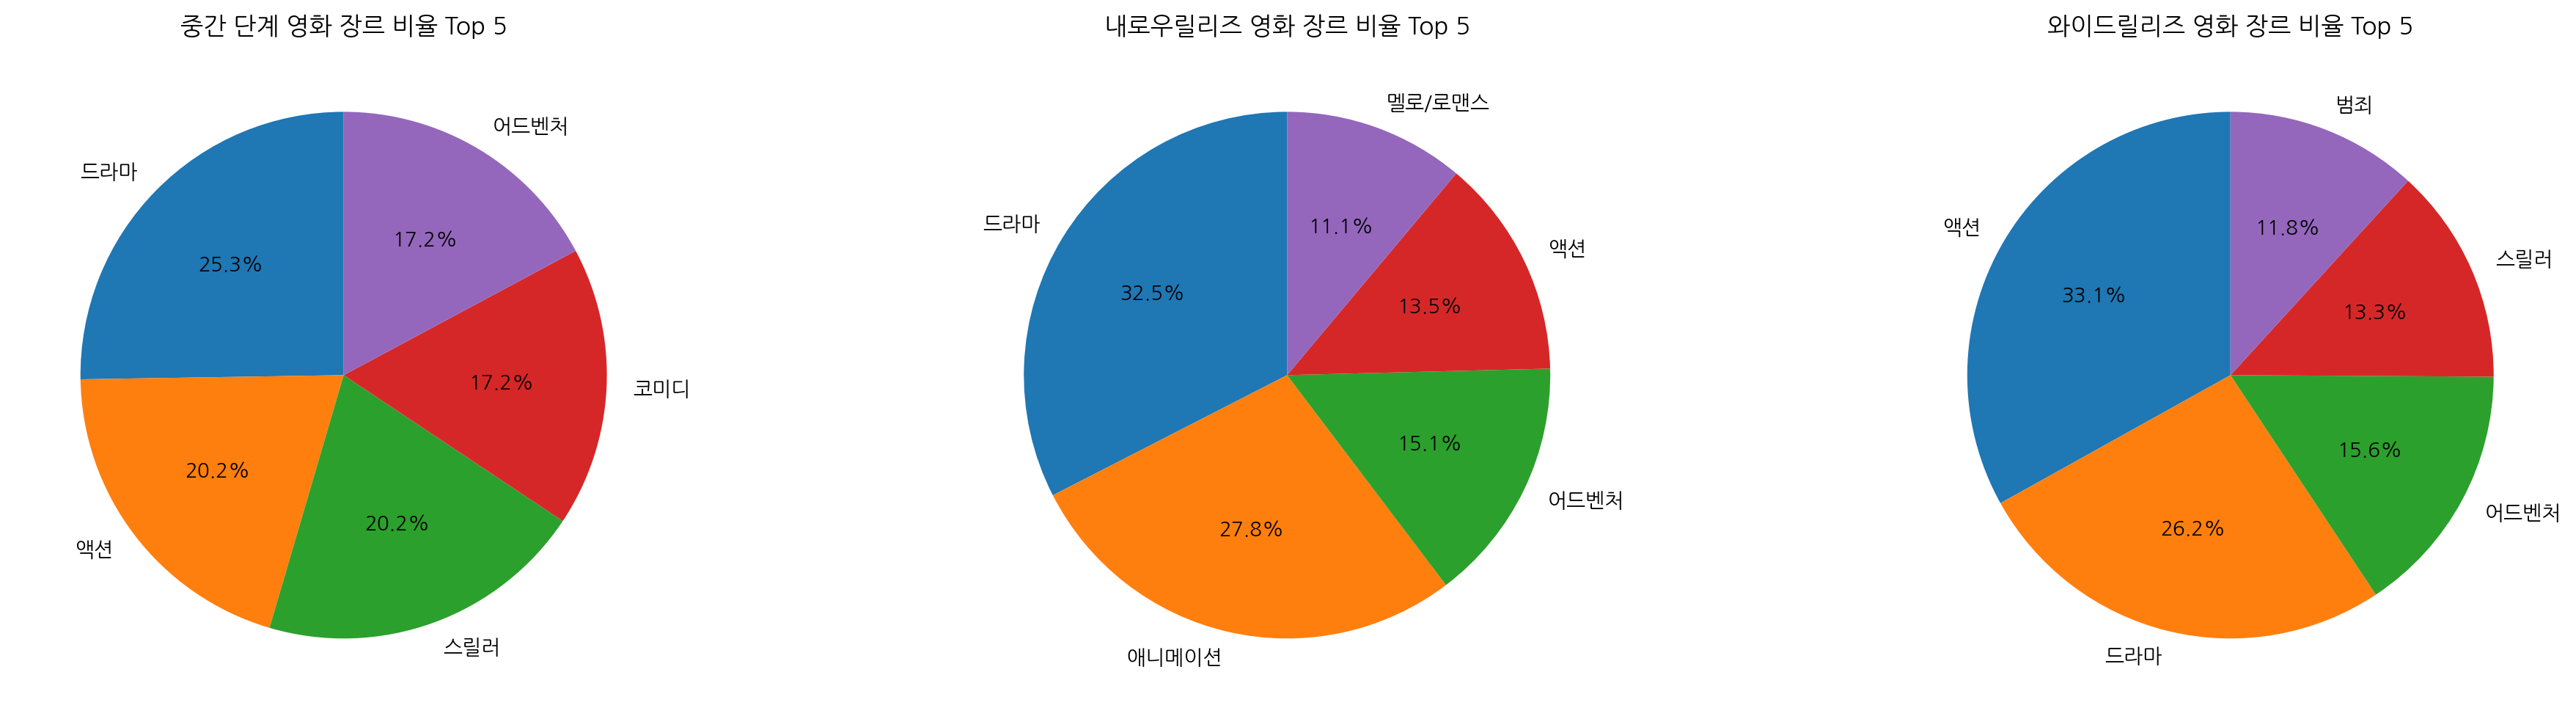

In [21]:
genre = ['사극', 'SF', '어드벤처', '액션', '범죄', '판타지', '가족', '미스터리', '스릴러', '뮤지컬', '코미디', '공포(호러)', '애니메이션', '드라마', '서부극(웨스턴)', '전쟁', '멜로/로맨스', '기타', '다큐멘터리', '공연', '성인물(에로)']

# 릴리즈 유형별 장르 비율 계산 및 시각화
fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # 릴리즈 유형별 subplot 생성

for i, size_category in enumerate(df['size_category'].unique()):  # 각 size_category별 반복
    # 해당 릴리즈 유형의 데이터를 필터링
    data = df[df['size_category'] == size_category]
    
    # 장르 열에서 합계를 계산하여 비율로 변환
    genre_counts = data[genre].sum()  # 각 장르별 합계
    genre_ratio = (genre_counts / genre_counts.sum()).sort_values(ascending=False)  # 비율 계산
    
    # 상위 5개 장르 선택
    top5_genres = genre_ratio.head(5)
    
    # 원형 차트 생성
    ax[i].pie(top5_genres, labels=top5_genres.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
    ax[i].set_title(f'{size_category} 장르 비율 Top 5')  # 서브플롯 제목

# 전체 플롯 표시
plt.tight_layout()
plt.show()


####  릴리즈 유형별 평균 스크린 수와 수익 비교

#### 릴리즈 유형별 개봉시기 비교
12,1,2에 개봉하는 영화의 개수가 와이드릴리즈 영화가 더 많을 것이다.

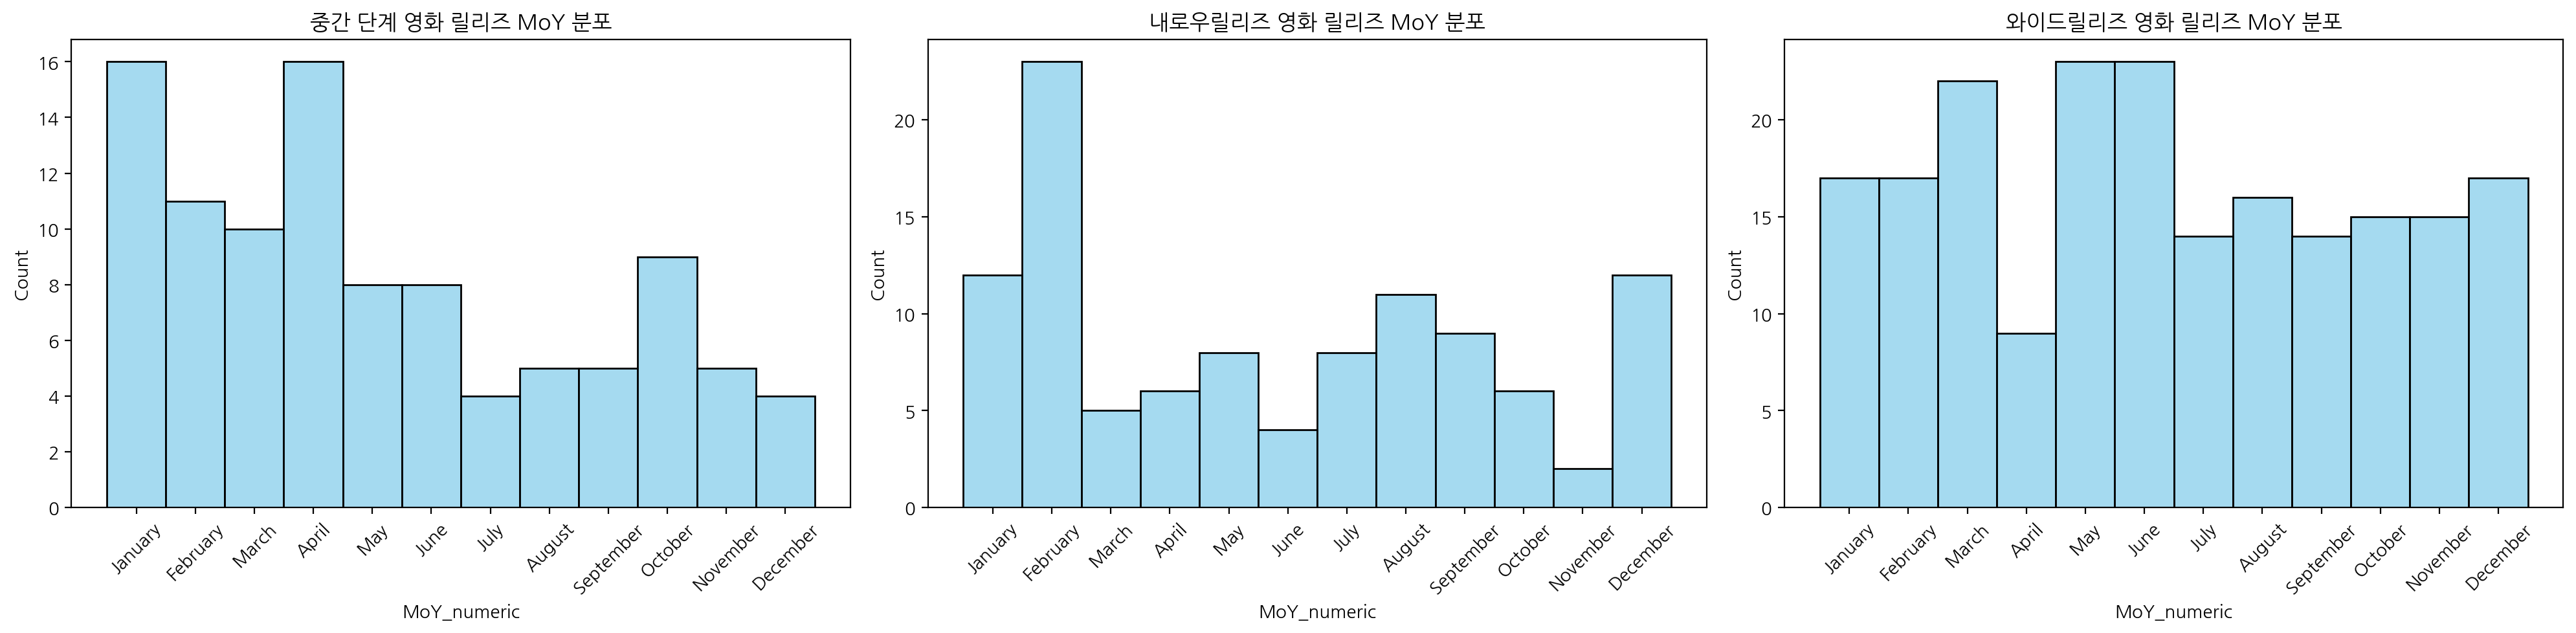

In [22]:
# MoY를 월 번호로 변환 (January -> 1, December -> 12)
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# MoY를 숫자로 변환하여 새로운 열에 저장
df['MoY_numeric'] = df['MoY'].map(month_map)

# 릴리즈 유형별 MoY 분포 시각화 histogram
fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # 릴리즈 유형별 subplot 생성

for i, size_category in enumerate(df['size_category'].unique()):  # 각 size_category별 반복
    # 해당 릴리즈 유형의 데이터를 필터링
    data = df[df['size_category'] == size_category].drop_duplicates('movie_title')
    
    # MoY 분포 시각화 (숫자로 변환한 MoY 사용)
    sns.histplot(data['MoY_numeric'], bins=12, ax=ax[i], color='skyblue', discrete=True)
    
    ax[i].set_title(f'{size_category} 릴리즈 MoY 분포')  # 서브플롯 제목
    ax[i].set_xticks(range(1, 13))  # x축을 1~12로 설정 (1월부터 12월까지)
    ax[i].set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                           'September', 'October', 'November', 'December'], rotation=45)  # 월 이름으로 설정

plt.tight_layout()
plt.show()

#### 릴리즈 유형별 배급사 분석

In [23]:
#각 릴리즈 유형에 해당하는 '배급사'종류, '배급사 군'개수 value_counts
df[df['size_category']=='와이드릴리즈 영화']['배급사'].value_counts().to_frame()

,count
배급사,
씨제이이앤엠(주),510
워너브러더스 코리아(주),360
(주)넥스트엔터테인먼트월드(NEW),285
(주)쇼박스,255
이십세기폭스코리아(주),240
월트디즈니컴퍼니코리아 유한책임회사,240
유니버설픽쳐스인터내셔널 코리아(유),240
롯데쇼핑㈜롯데엔터테인먼트,210
롯데컬처웍스(주)롯데엔터테인먼트,150


In [24]:
df[df['size_category']=='내로우릴리즈 영화']['배급사'].value_counts().to_frame()

,count
배급사,
(주)넥스트엔터테인먼트월드(NEW),150
유니버설픽쳐스인터내셔널 코리아(유),150
(주)이수C&E,135
CGV아트하우스,105
씨제이이앤엠(주),90
"(주)제이앤씨미디어그룹, TCO(주)더콘텐츠온",60
이십세기폭스코리아(주),60
오드,45
소니픽쳐스엔터테인먼트코리아주식회사극장배급지점,45


In [25]:
df[df['size_category']=='중간 단계 영화']['배급사'].value_counts().to_frame()

,count
배급사,
유니버설픽쳐스인터내셔널 코리아(유),240
워너브러더스 코리아(주),150
롯데쇼핑㈜롯데엔터테인먼트,135
(주)넥스트엔터테인먼트월드(NEW),135
이십세기폭스코리아(주),90
씨네그루(주)키다리이엔티,90
월트디즈니컴퍼니코리아 유한책임회사,75
씨제이이앤엠(주),75
메가박스중앙(주)플러스엠,75


In [26]:
df.drop_duplicates('movie_title')['배급사군'].value_counts().to_frame()

,count
배급사군,
3,311
2,65
1,33


In [27]:
df[df['size_category']=='중간 단계 영화'].drop_duplicates('movie_title')['배급사군'].value_counts().to_frame()

,count
배급사군,
3,76
2,20
1,5


In [28]:
df[df['size_category']=='와이드릴리즈 영화'].drop_duplicates('movie_title')['배급사군'].value_counts().to_frame()

,count
배급사군,
3,191
2,11


In [29]:
df[df['size_category']=='내로우릴리즈 영화'].drop_duplicates('movie_title')['배급사군'].value_counts().to_frame()

,count
배급사군,
3,44
2,34
1,28


### 영화 상영 기간에 따른 EDA

#### 상영 기간별 영화 분포도
oulier들이 꽤 존재. 이들은 재개봉한 영화도 포함되어서 일듯.

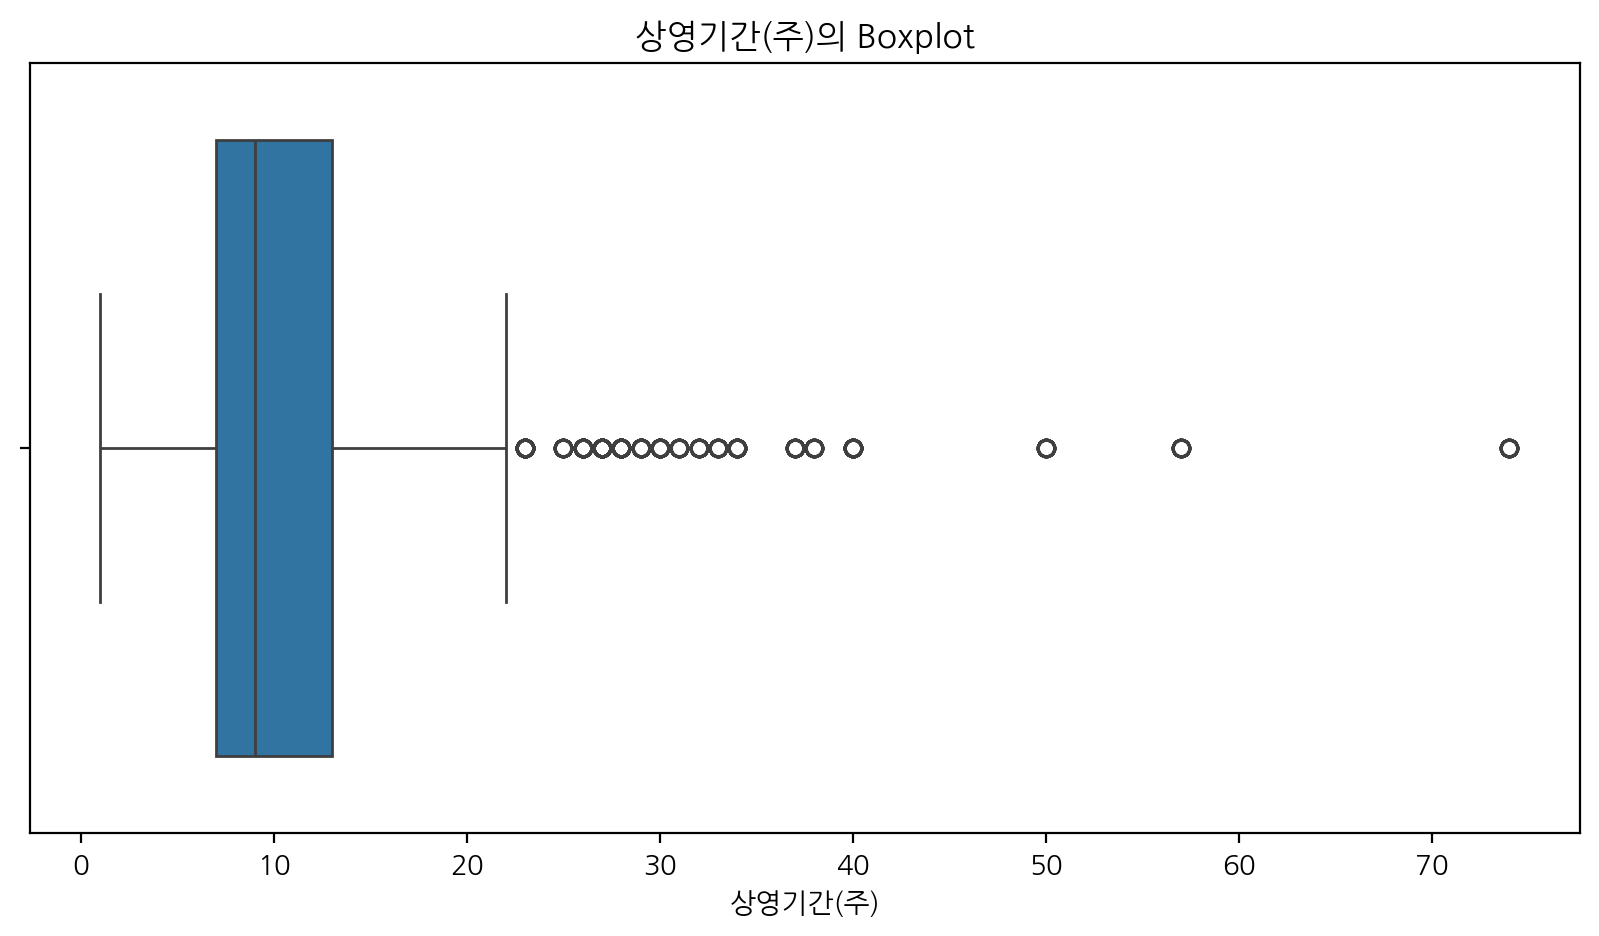

In [30]:
#영화 중복 제거
data = df.drop_duplicates('movie_title')

#상영 기간 boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='상영기간(주)', data=df)
plt.title('상영기간(주)의 Boxplot')
plt.show()

In [31]:
#이상치 제거 - wisker를 벗어나는 데이터는 이상치로 판단
q1 = df['상영기간(주)'].quantile(0.25)
q3 = df['상영기간(주)'].quantile(0.75)
median = df['상영기간(주)'].median()
print(q1, q3, median)
iqr = q3 - q1
outlier_min = q1 - 1.5 * iqr
outlier_max = q3 + 1.5 * iqr

#이상치에 해당하는 데이터 영화명 리스트로 출력
print(df[(df['상영기간(주)'] < outlier_min)]['movie_title'].drop_duplicates().tolist())
print(df[(df['상영기간(주)'] > outlier_max)]['movie_title'].drop_duplicates().tolist())
#이상치 제거
#df = df[(df['상영기간(주)'] >= outlier_min) & (df['상영기간(주)'] <= outlier_max)]

7.0 13.0 9.0
[]
['캐롤', '동주', '스포트라이트', '귀향', '나의 소녀시대', '싱 스트리트', '부산행', '벤허', '터닝메카드W: 블랙미러의 부활', '문라이트', '미녀와 야수', '서서평, 천천히 평온하게', '불한당: 나쁜 놈들의 세상', '내 사랑', '예수는 역사다', '덩케르크', '택시운전사', '아이 캔 스피크', '너의 췌장을 먹고 싶어', '뽀로로 극장판 공룡섬 대모험', '위대한 쇼맨', '원더', '콜 미 바이 유어 네임', '어느 가족', '스타 이즈 본', '바울', '보헤미안 랩소디', '그린 북', '가버나움', '알라딘', '기생충', '천로역정: 천국을 찾아서']


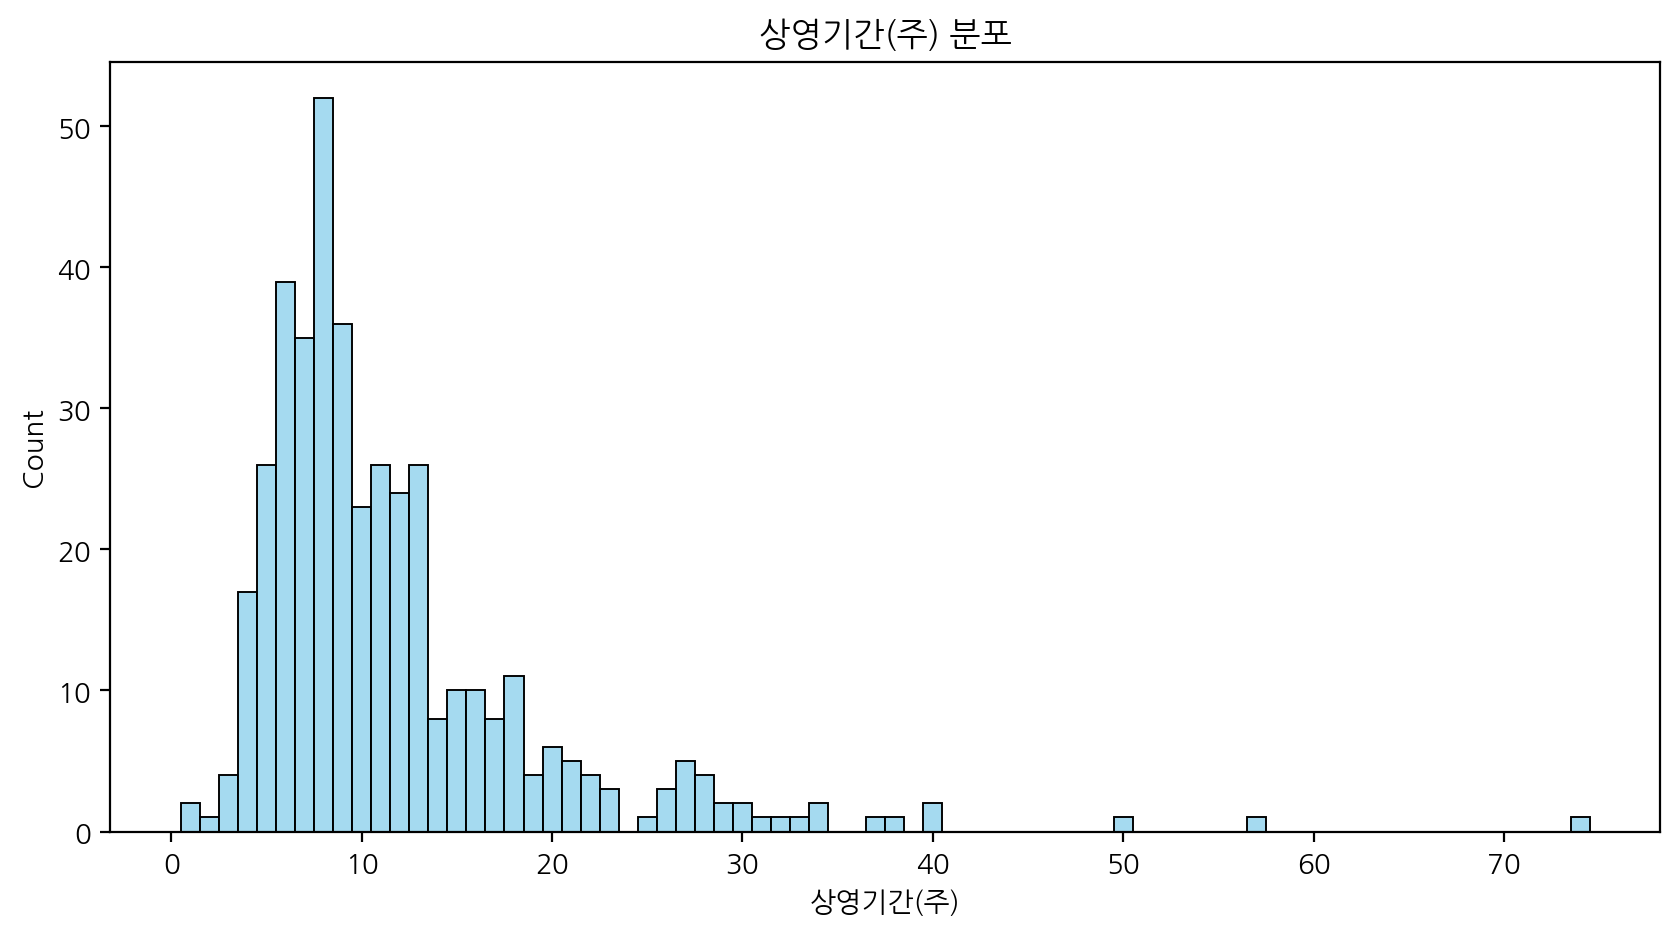

In [32]:
#영화 중복 제거
data = df.drop_duplicates('movie_title')

#상영 기간별 histogram

plt.figure(figsize=(10, 5))
sns.histplot(data['상영기간(주)'], bins=30, color='skyblue', discrete=True)
plt.title('상영기간(주) 분포')
plt.show()

#### 상영 기간별 영화 장르 분석
그 이유는 아마도 이 장르가 결말에서의 반전이나 범인이 밝혀지는 등과 같은 독특한 내용적 특성을 가지고 있기에, 장기 상영 시에 관객의 입소문을 통해 오히려 흥행에 부정적인 영향력을 나타낼 것이라고 평가되었기 때문이라고 분석할 수 있다.

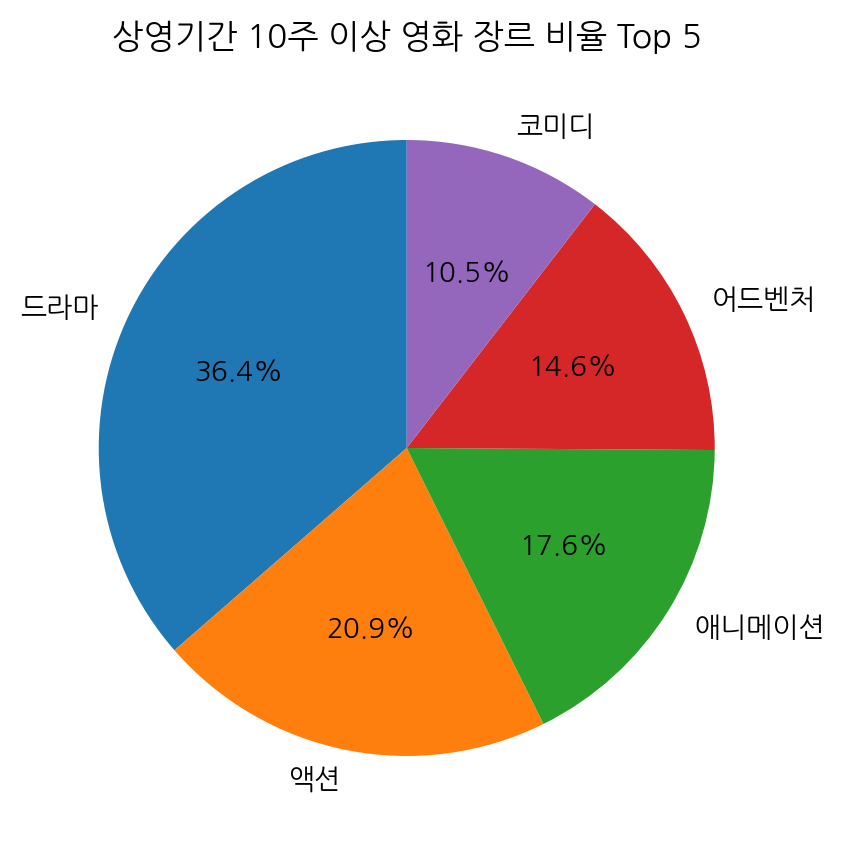

In [33]:
#9주 이상 상영된 영화의 장르별 개수 및 비율(median)
data = df[df['상영기간(주)'] > 9].drop_duplicates('movie_title')

# 장르 열에서 합계를 계산하여 비율로 변환
genre_counts = data[genre].sum()  # 각 장르별 합계
genre_ratio = (genre_counts / genre_counts.sum()).sort_values(ascending=False)  # 비율 계산

# 상위 5개 장르 원그래프로 시각화
plt.figure(figsize=(10, 5))
plt.pie(genre_ratio.head(5), labels=genre_ratio.head(5).index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title('상영기간 10주 이상 영화 장르 비율 Top 5')
plt.show()

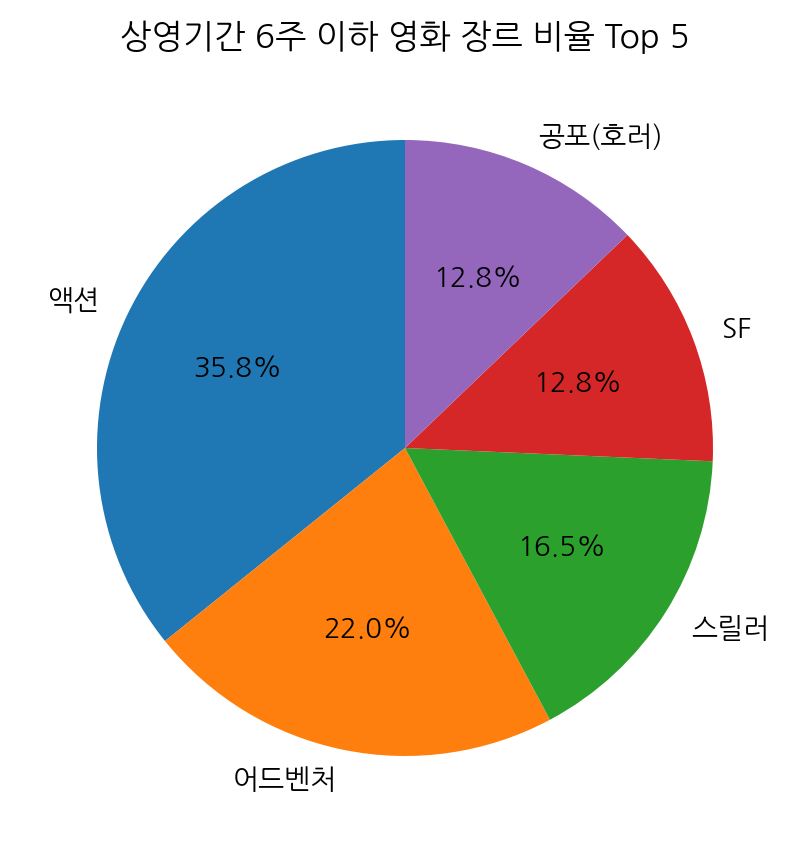

In [34]:
#7주 미만 상영된 영화의 장르별 개수 및 비율(25%)
data = df[df['상영기간(주)'] < 7].drop_duplicates('movie_title')

# 장르 열에서 합계를 계산하여 비율로 변환
genre_counts = data[genre].sum()  # 각 장르별 합계
genre_ratio = (genre_counts / genre_counts.sum()).sort_values(ascending=False)  # 비율 계산

# 상위 5개 장르 원그래프로 시각화
plt.figure(figsize=(10, 5))
plt.pie(genre_ratio.head(5), labels=genre_ratio.head(5).index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title('상영기간 6주 이하 영화 장르 비율 Top 5')
plt.show()

#### 배급사군별 상영 기간 분포
예술영화 전용관을 확보하고 있는 배급사가 전체 영화의 60% 이상을 6주 이상 상영하고 있는 것으로 나타나고 있다. 이러한 결과는 자신들이 소유한 극장에 적합한 
영화를 직접 선별해서 배급할 수 있는 체계를 지니고 있는 배급사들을 중심으로 보다 안정적인 영화의 상영 이루어지고 있다는 사실을 보여주고 있다. 그렇지 못한 대부분의 배급사들은 영화 자체의 초기 평가에 따라 상영 기간이 결정되는 경우가 많았다. 국내 3대 메이저 배급사인 CJ(131편 중 70편, 53.4%), 쇼박스(73편 중 39편, 53.4%), 롯데계열사(54편 중 26편, 48.1%) 등의 개봉작들 중 6주 이상 상영된 영화와 그렇지 못한 영화의 비율이 비슷하게 나타나고 있었다. 

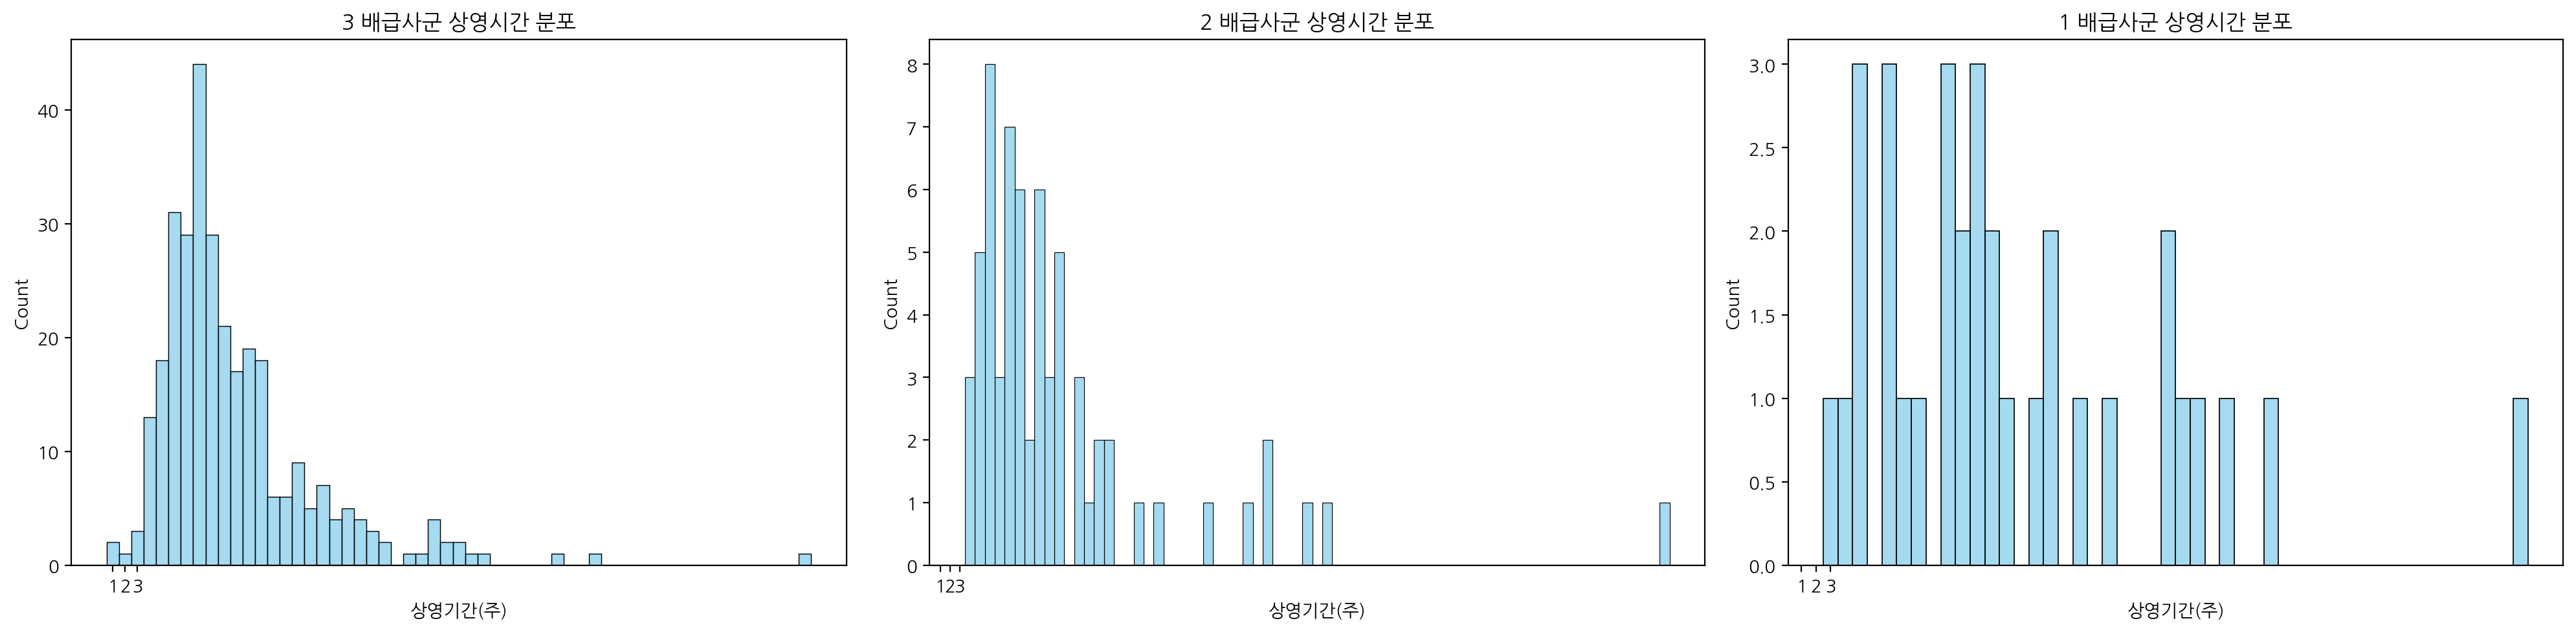

In [35]:
# 배급사군별 상영 기간 유형별 비율 
# 릴리즈 유형별 MoY 분포 시각화 histogram
fig, ax = plt.subplots(1, 3, figsize=(20, 5))  # 릴리즈 유형별 subplot 생성

for i, size_category in enumerate(df['배급사군'].unique()):  # 각 size_category별 반복
    # 해당 릴리즈 유형의 데이터를 필터링
    data = df[df['배급사군'] == size_category].drop_duplicates('movie_title')
    
    # MoY 분포 시각화 (숫자로 변환한 MoY 사용)
    sns.histplot(data['상영기간(주)'], bins=20, ax=ax[i], color='skyblue', discrete=True)
    
    ax[i].set_title(f'{size_category} 배급사군 상영시간 분포')  # 서브플롯 제목
    ax[i].set_xticks(range(1, 4))  # x축을 1~3로 설정 

plt.tight_layout()
plt.show()

141 170


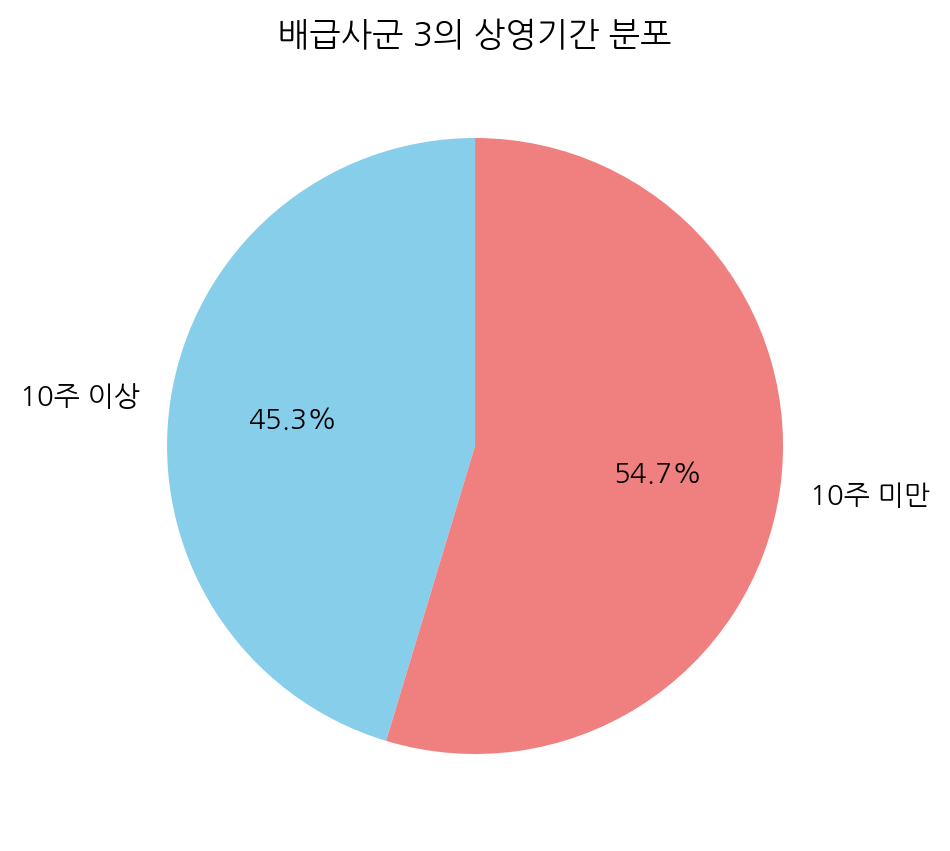

In [36]:
#배급사군 3에 해당하는 데이터만 추출
data = df[df['배급사군']==3].drop_duplicates('movie_title')
total = data['movie_title'].nunique()
#배급사군 3에 해당하는 데이터 중 상영기간이 10주 이상인 영화의 개수, 10주 미만인 영화의 개수
long = data[data['상영기간(주)'] >= 10]['movie_title'].nunique()
short = data[data['상영기간(주)'] < 10]['movie_title'].nunique()
print(long, short)
long = long / total * 100
short = short / total * 100
#data 중 상영기간이 10주 이상, 10주 미만인 영화의 개수 비율 시각화(원그래프)
plt.figure(figsize=(10, 5))
plt.pie([long, short], labels=['10주 이상', '10주 미만'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('배급사군 3의 상영기간 분포')
plt.show()

## 결론
이처럼 배급사별로 영화 시장에서의 지배력이 매우 불균등한 상황에서, 연구자는 
소규모의 개봉관을 확보하여 오랫동안 상영하는 영화의 흥행에 영향을 미치는 요인들과 와
이드릴리즈를 통해 단기간에 치고 빠지는 영화의 흥행에 영향을 미치는 요인들은 분명히 다
를 것이라 판단했다.